In [1]:
using ValueShapes
using ArraysOfArrays
using StatsBase 
using LinearAlgebra
using Statistics
using BAT
using Distributions 
using IntervalSets

using HCubature

using Plots
using Colors
using ColorSchemes
using LaTeXStrings

pyplot(size=(750,500))

Plots.PyPlotBackend()

In [2]:
# Define target density function: 

density_f(x; μ1=-1.5, μ2=1.5, σ=0.5) = (1/2)*(pdf(Normal(μ1, σ),x) + pdf(Normal(μ2, σ),x))

density_f (generic function with 1 method)

In [27]:
# Generate MCMC Samples using BAT

prior = NamedTupleDist(x =[-10.0 .. 10.0] )

Norm_prior = 20

log_likelihood = let f = density_f
    params ->  LogDVal(log(f(params.x[1])))
end

posterior = PosteriorDensity(log_likelihood, prior)

nsamples = 10^4
nchains = 6

samples = bat_sample(posterior, (nsamples, nchains), MetropolisHastings()).result;

┌ Info: Trying to generate 6 viable MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:199
┌ Info: Selected 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:308
┌ Info: Begin tuning of 6 MCMC chain(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:72
┌ Info: MCMC Tuning cycle 1 finished, 6 chains, 0 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:104
┌ Info: MCMC Tuning cycle 2 finished, 6 chains, 6 tuned, 6 converged.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:104
┌ Info: MCMC tuning of 6 chains successful after 2 cycle(s).
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:108


In [28]:
# Create histogram

samples_flat = flatview(unshaped.(samples.v))[1,:]
bins = range(minimum(samples_flat), stop = maximum(samples_flat), length = 100)
hist = fit(Histogram, samples_flat, weights(samples.weight), bins);
hist = normalize(hist, mode=:pdf);

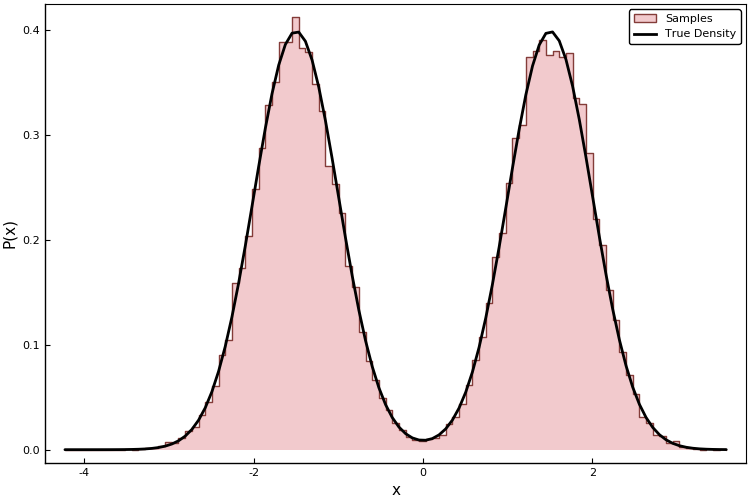

In [29]:
line_colors = ColorSchemes.tab20b

plot(hist, 
    seriestype = :steps, 
    linecolor=line_colors[13], 
    linealpha=1,
    fill=true, 
    fillcolor=line_colors[16],
    fillalpha=0.5, 
    label="Samples"
)

plot!(bins, x->density_f(x), 
    linecolor=:black,
    lw=2, 
    label="True Density")

plot!(grid=:false, frame=true, xlabel="x", ylabel="P(x)")

## Harmonic Mean Calculation: 

In [30]:
# CUBA integral: 

cuba_integral = hcubature(density_f, [-10.0], [10])

([1.0], 3.0683084910385424e-9)

In [31]:
ahmi_integral = bat_integrate(samples).result .* Norm_prior

avoid_whitening_dims = Int64[]


┌ Info: Harmonic Mean Integration started. Samples in dataset 1 / 2: 	30000 / 29999	Parameters:	1
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:96
┌ Info: Data Whitening.
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:111
┌ Info: Apply Whitening Transformation to Data Set 2
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:120
┌ Info: Create Space Partitioning Tree
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:132
┌ Info: Determine Hyperrectangle Starting Samples
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:148
┌ Warning: Returned minimum number of starting points: 16
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hyper_rectangle.jl:104
┌ War

"Integration" = "Integration"


┌ Info: Create 33 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:9
┌ Info: Updating 33 Hyperrectangles using 20 thread(s)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/hm_integration_rectangle.jl:27
┌ Info: Integrating 33 Hyperrectangles
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:388
┌ Info: Estimating Uncertainty (cov. weighted result)
└ @ BAT /home/iwsatlas1/vhafych/MPP-Project/gitrepos/BAT.jl/src/integration/ahmi/harmonic_mean_integration.jl:62


1.019 ± 0.016

In [33]:
likelihood_val = exp.(samples.logd)

V = maximum(samples_flat) - minimum(samples_flat)

I_hm = (length(likelihood_val) * V) /(sum(1 ./ likelihood_val)) * Norm_prior

0.05582166264641069